# Recommender Systems
- Author: Chris Hodapp
- Date: 2018-02-04
- Done as part of a [SharpestMinds](https://www.sharpestminds.com/) skills test

The aim of this notebook is to briefly explain *recommender systems*, show some specific examples of them, and to demonstrate simple implementations of them in Python/NumPy/Pandas.

Recommender systems are quite a broad subject on their own.  This notebook focuses on movie recommendations from explicit ratings. That is, it's focusing on the scenario in which:

- There are a large number of users and a large number of movies.
- Users have supplied ratings on certain movies.
- The movies are different for each user, and the vast majority of users have rated only a tiny fraction of the overall movies.

The goal is to make predictions based on this data, such as:

- How a given user will most likely rate specific movies they have not seen before
- What "new" movies a system might recommended to them

This uses the [movielens 100k](https://grouplens.org/datasets/movielens/100k/) dataset, (which you can download yourself, and should if you wish to run the code). It has 100,000 ratings total by 944 users on 1,683 different movies. As far as movie datasets go, it's fairly old (1998) and fairly small (the Netflix dataset from 10+ years ago has 1000 times as many ratings), but it's enough to work with. In any case, MovieLens has [newer and larger](https://grouplens.org/datasets/movielens/latest/) datasets too.

I refer several times in this notebook to the free textbook [Mining of Massive Datasets](http://www.mmds.org/) (hereafter, just "MMDS"), mostly to chapter 9, *Recommendation Systems*.  It's worth reading if you want to know more.

## Organization

This notebook is organized roughly as follows:

- Explanation of Collaborative Filtering
  - Slope One Predictors
  - SVD / UV decomposition method
- Explanation of Content-Based Filtering
- Implementation on movielens dataset
  - Loading data
  - Exploration and aggregation
  - Slope One implementation
  - SVD method
- Running the same algorithms in scikit-surprise

I try to clearly implement everything I talk about here, and be specific about the method. Some other work I read in this area had me rather frustrated with its tendency to completely ignore implementation details that are both critical and very difficult to articulate questions on, and this is something I try to avoid. I'd like for you to be able to execute it yourself, to build intuition on how the math works, to understand why the code implements the math how it does, and to have good starting points for further research.

In the Slope One explanation, this means I give perhaps a needless amount of detail behind the linear algebra implementation, but maybe some will find it valuable besides just me when I try to read this code in 3 months.

## scraps

In addition to the normal steps of loading data and doing basic transformations, this works through implementations of:

- Slope One Predictors - a collaborative filtering method, particularly, a neighborhood model.
- An "SVD" algorithm which [Simon Funk](http://sifter.org/~simon/journal/20061211.html) popularized for the Netflix prize - another collaborative filtering method, this one a latent factor model based on matrix factorization.

It also reproduces similar results with [scikit-surprise](http://surpriselib.com/), which implements these algorithms (and many others).

## TODOs

- Bipolar Slope One?
- Content-based filtering (look in MMDS)
- Explain code a bit better (ditch the formal Python version)
- Merge in all the Slope One post content, export to Markdown, and put this file on my blag as well

# Preliminaries

## Utility Matrix

The notion of the *utility matrix* comes up in many methods as a way of
expressing the ratings data. For one thing, this opens up the data to an
array of linear algebra operations (such as matrix multiplication and
[SVD](https://en.wikipedia.org/wiki/Singular-value_decomposition)) that
are useful for transforming the data, meaningful for interpreting it,
very readily-available and optimized, and provide a common language for
discussing and analyzing what we are actually doing to the data.  (For some
examples of this, check out section 11.3.2 in [MMDS](http://www.mmds.org/).)

In a utility matrix, each row represents one user, each column represents
one item (a movie, in our case), and each element represents a user's
rating of an item.  If we have $n$ users and $m$ movies, then this a
$n \times m$ matrix $U$ for which $U_{k,i}$ is user $k$'s rating for
movie $i$ - assuming we've numbered our users and our movies.

Users have typically rated only a fraction of movies, and so most of
the elements of this matrix are unknown. Algorithms represent this
in different ways; the use of [sparse matrices](https://en.wikipedia.org/wiki/Sparse_matrix)
where a value of 0 signifies unknown information is common.

(TODO: Give an example)

# Collaborative Filtering

## Slope One Predictors

This method is described in the paper [Slope One Predictors for Online Rating-Based Collaborative Filtering](https://arxiv.org/pdf/cs/0702144v1.pdf).  Despite the complex-sounding name, they are
wonderfully simple to understand and implement, and very fast.

I'll give a contrived example below to explain them.

Consider a user Bob.  Bob is enthusiastic, but has rather simple
tastes: he mostly just watches Clint Eastwood movies.  In fact, he's
watched and rated nearly all of them, and basically nothing else.

Now, suppose we want to predict how much Bob will like something
completely different and unheard of (to him at least), like... I don't
know... *Citizen Kane*.

Here's Slope One in a nutshell:

1. First, find the users who rated both *Citizen Kane* and any of
   the Clint Eastwood movies that Bob rated.
2. Now, for each movie that comes up above, compute a _deviation_
   which tells us: On average, how differently (i.e. how much higher
   or lower) did users rate Citizen Kane compared to this movie?  (For
   instance, we'll have a number for how *Citizen Kane* was rated
   compared to *Dirty Harry*, and perhaps it's +0.6 - meaning that on
   average, users who rated both movies rated *Citizen Kane* about 0.6
   stars above *Dirty Harry*.  We'd have another deviation for
   *Citizen Kane* compared to *Gran Torino*, another for *Citizen
   Kane* compared to *The Good, the Bad and the Ugly*, and so on - for
   every movie that Bob rated, provided that other users who rated
   *Citizen Kane* also rated the movie.)
3. If that deviation between *Citizen Kane* and *Dirty Harry* was
   +0.6, it's reasonable that adding 0.6 from Bob's rating on *Dirty
   Harry* would give one prediction of how Bob might rate *Citizen
   Kane*.  We can then generate more predictions based on the ratings
   he gave the other movies - anything for which we could compute a
   deviation.
4. To turn this to a single prediction, we could just average all
   those predictions together.

One variant, Weighted Slope One, is nearly identical.  The only
difference is in how we average those predictions in step #4.  In
Slope One, every deviation counts equally, no matter how many users
had differences in ratings averaged together to produce it.  In
Weighted Slope One, deviations that came from larger numbers of users
count for more (because, presumably, they are better estimates).

Or, in other words: If only one person rated both *Citizen Kane* and
the lesser-known Eastwood classic *Revenge of the Creature*, and they
happened to think that *Revenge of the Creature* deserved at least 3
more stars, then with Slope One, this deviation of -3 would carry
exactly as much weight as thousands of people rating *Citizen Kane* as
about 0.5 stars below *The Good, the Bad and the Ugly*.  In Weighted
Slope One, that latter deviation would count for thousands of times as
much.  The example makes it sound a bit more drastic than it is.

### Linear Algebra Tricks

Those who aren't familiar with matrix methods or algebra can probably
skip this section. Everything I've described above, you can compute
given just the movielens dataset and some basic arithmetic.  You don't
need any complicated numerical methods.

However, the entire Slope One method can be implemented in a very fast
and simple way with a couple matrix operations.  What I describe here
is the same way I implement it in Python later in the notebook.

First, we need to have our data encoded as an $n \times m$ utility
matrix (see a few sections above if *utility matrix* is unfamiliar).
As noted, most elements of this matrix are unknown as users have rated
only a fraction of movies. We can represent this with another
$n \times m$ matrix (specifically a binary matrix), a 'mask' $M$ in
which $M_{k,i}$ is 1 if user $k$ supplied a rating for movie $i$, and
otherwise 0.

I mentioned *deviation* above and gave an informal definition of it.
The paper gaves a formal but rather terse definition below of the
average deviation of item $i$ with respect to item $j$:

$$\textrm{dev}_{j,i} = \sum_{u \in S_{j,i}(\chi)} \frac{u_j - u_i}{card(S_{j,i}(\chi))}$$

where:

- $u_j$ and $u_i$ mean: user $u$'s ratings for movies $i$ and $j$, respectively
- $u \in S_{j,i}(\chi)$ means: all users $u$ who, in the dataset we're
  training on, provided a rating for both movie $i$ and movie $j$
- $card$ is the cardinality of that set, i.e. for
  ${card(S_{j,i}(\chi))}$ it is just how many users rated both $i$ and
  $j$.

That denominator does depend on $i$ and $j$, but doesn't depend on the
summation term, so it can be pulled out, and also, we can split up the
summation as long as it is kept over the same terms:

$$\textrm{dev}_{j,i} = \frac{1}{card(S_{j,i}(\chi))} \sum_{u \in
S_{j,i}(\chi)} u_j - u_i = \frac{1}{card(S_{j,i}(\chi))}\left(\sum_{u
\in S_{j,i}(\chi)} u_j - \sum_{u \in S_{j,i}(\chi)} u_i\right)$$

* TODO: These need some actual matrices to illustrate*

Let's start with computing ${card(S_{j,i}(\chi))}$, the number of
users who rated both movie $i$ and movie $j$.  Consider column $i$ of
the mask $M$.  For each value in this column, it equals 1 if the
respective user rated movie $i$, or 0 if they did not.  Clearly,
simply summing up column $i$ would tell us how many users rated movie
$i$, and the same applies to column $j$ for movie $j$.

Now, suppose we take element-wise logical AND of columns $i$ and $j$.
The resultant column has a 1 only where both corresponding elements
were 1 - where a user rated both $i$ and $j$.  If we sum up this
column, we have exactly the number we need: the number of users who
rated both $i$ and $j$.

Some might notice that "elementwise logical AND" is just "elementwise
multiplication", thus "sum of elementwise logical AND" is just "sum of
elementwise multiplication", which is: dot product.  That is,
${card(S_{j,i}(\chi))}=M_j \bullet M_i$ if we use $M_i$ and $M_j$ for
columns $i$ and $j$ of $M$.

However, we'd like to compute deviation as a matrix for all $i$ and
$j$, so we'll likewise need ${card(S_{j,i}(\chi))}$ for every single
combination of $i$ and $j$ - that is, we need a dot product between
every single pair of columns from $M$.  Incidentally, "dot product of
every pair of columns" happens to be almost exactly matrix
multiplication; note that for matrices $A$ and $B$, element $(x,y)$ of
the matrix product $AB$ is just the dot product of /row/ $x$ of $A$
and /column/ $y$ of $B$ - and that matrix product as a whole has this
dot product between every row of $A$ and every column of $B$.

We wanted the dot product of every column of $M$ with every column of
$M$, which is easy: just transpose $M$ for one operand.  Then, we can
compute our count matrix like this:

$$C=M^\top M$$

Thus $C_{i,j}$ is the dot product of column $i$ of $M$ and column $j$
of $M$ - or, the number of users who rated both movies $i$ and $j$.

That was the first half of what we needed for $\textrm{dev}_{j,i}$.
We still need the other half:

$$\sum_{u \in S_{j,i}(\chi)} u_j - \sum_{u \in S_{j,i}(\chi)} u_i$$

We can apply a similar trick here.  Consider first what $\sum_{u \in
S_{j,i}(\chi)} u_j$ means: It is the sum of only those ratings of
movie $j$ that were done by a user who also rated movie $i$.
Likewise, $\sum_{u \in S_{j,i}(\chi)} u_j$ is the sum of only those
ratings of movie $i$ that were done by a user who also rated movie
$j$.  (Note the symmetry: it's over the same set of users, because
it's always the users who rated both $i$ and $j$.)

## "SVD" algorithm

### Model & Background

This isn't a very complicated model, but the naming (or lack thereof) is a little confusing.  Surprise calls it an SVD algorithm, but it doesn't exactly compute Singular Value Decomposition, though it's SVD-like - which can be confusing, since some other methods explicitly use SVD to solve very similar problems.

References on this model are in a few different places:

- [SVD](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD) in Surprise gives enough formulas to implement from.
- Simon Funk's post [Netflix Update: Try This at Home](http://sifter.org/~simon/journal/20061211.html) is an excellent overview of the rationale and of some practical concerns on how to run this on the much larger Netflix dataset (100,000,000 ratings, instead of 100,000).
- The paywalled article [Matrix Factorization Techniques for Recommender Systems](http://ieeexplore.ieee.org/abstract/document/5197422/) gives a little background from a higher level.

I already said that this is still a collaborative filtering approach. More specifically, it is a *latent factor model* approach to collaborative filtering.  That is, the model tries to derive from patterns in the data some number of hidden factors which can explain the ratings. For us, these factors might correspond to something concrete, such as the movie's budget, or might progress to more vague things such as movement along some continuum of genres, film styles, themes, or characters... or, they might just be meaningless.  Later on in the implementation, I show some examples of visualizing those latent factors.

More specifically still: It is a latent factor model that uses low-rank [matrix factorization](https://en.wikipedia.org/wiki/Matrix_decomposition).  Even more specifically: The matrix factorization is applied to solving a [matrix completion](https://en.wikipedia.org/wiki/Matrix_completion) problem.  (Matrix completion is a subject unto itself with many relevant methods to this topic. See the [matrix-completion-whirlwind](https://github.com/asberk/matrix-completion-whirlwind/blob/master/matrix_completion_master.ipynb) notebook for a much better explanation than I care to give here, and an implementation of [altMinSense/altMinComplete](https://arxiv.org/pdf/1212.0467).)

Finally: To solve this matrix factorization, it uses [stochastic gradient-descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent), and it does it without explicitly creating a utility matrix.

(Scraps: The UV-decomposition algorithm described in section 9.4 of [MMDS](http://www.mmds.org/) is very similar.)

(TODO: Explain utility matrix.)

(TODO: Explain what matrices it's even building.)

For completeness (and to verify it myself), I give the model and derive its gradients below.

### Prediction & Error Function

The prediction model is:

$$\hat{r}_{ui}=\mu + b_i + b_u + q_i^\top p_u$$

where:

- $u$ is a user
- $i$ is an item
- $\hat{r}_{ui}$ is user $u$'s predicted rating for item $i$
- $\mu$ is the overall average rating
- $b_i$ is per-item deviation for item $i$
- $b_u$ is per-user deviation for user $u$
- $q_i$ and $p_u$ are feature vectors for item $i$ and user $u$, respectively

The goal is to minimize $L_2$-regularized squared error:

$$E=\sum_{r_{ui} \in R_{\textrm{train}}} \left(r_{ui} - \hat{r}_{ui}\right)^2 + \lambda\left(b_i^2+b_u^2 + \lvert\lvert q_i\rvert\rvert^2 + \lvert\lvert p_u\rvert\rvert^2\right)$$

### Gradients & Gradient-Descent Updates

This error function is easily differentiable with respect to model parameters $b_i$, $b_u$, $q_i$, and $p_u$, so a normal approach is gradient-descent.  Finding gradient with respect to $b_i$ is straightforward:

$$
\begin{split}
\frac{\partial E}{\partial b_i} &= \sum_{r_{ui}} \frac{\partial}{\partial b_i} \left(r_{ui} - (\mu + b_i + b_u + q_i^\top p_u)\right)^2 + \frac{\partial}{\partial b_i}\lambda\left(b_i^2+b_u^2 + \lvert\lvert q_i\rvert\rvert^2 + \lvert\lvert p_u\rvert\rvert^2\right) \\
\frac{\partial E}{\partial b_i} &= \sum_{r_{ui}} 2\left(r_{ui} - (\mu + b_i + b_u + q_i^\top p_u)\right)(-1) + 2 \lambda b_i \\
\frac{\partial E}{\partial b_i} &= 2 \sum_{r_{ui}} \left(\lambda b_i + r_{ui} - \hat{r}_{ui}\right)
\end{split}
$$

Gradient with respect to $p_u$ proceeds similarly:

$$
\begin{split}
\frac{\partial E}{\partial p_u} &= \sum_{r_{ui}} \frac{\partial}{\partial p_u} \left(r_{ui} - (\mu + b_i + b_u + q_i^\top p_u)\right)^2 + \frac{\partial}{\partial p_u}\lambda\left(b_i^2+b_u^2 + \lvert\lvert q_i\rvert\rvert^2 + \lvert\lvert p_u\rvert\rvert^2\right) \\
\frac{\partial E}{\partial p_u} &= \sum_{r_{ui}} 2\left(r_{ui} - \hat{r}_{ui}\right)\left(-\frac{\partial}{\partial
p_u}q_i^\top p_u \right) + 2 \lambda p_u \\
\frac{\partial E}{\partial p_u} &= \sum_{r_{ui}} 2\left(r_{ui} - \hat{r}_{ui}\right)(-q_i^\top) + 2 \lambda p_u \\
\frac{\partial E}{\partial p_u} &= 2 \sum_{r_{ui}} \lambda p_u - \left(r_{ui} - \hat{r}_{ui}\right)q_i^\top
\end{split}
$$

Gradient with respect to $b_u$ is identical form to $b_i$, and gradient with respect to $q_i$ is identical form to $p_u$, except that the variables switch places.  The full gradients then have the standard form for gradient descent, i.e. a summation of a gradient term for each individual data point, so they turn easily into update rules for each parameter (which match the ones in the Surprise link) after absorbing the leading 2 into learning rate $\gamma$ and separating out the summation over each data point. That's given below, with $e_{ui}=r_{ui} - \hat{r}_{ui}$:

$$
\begin{split}
\frac{\partial E}{\partial b_i} &= 2 \sum_{r_{ui}} \left(\lambda b_i + e_{ui}\right)\ \ \ &\longrightarrow b_i' &= b_i - \gamma\frac{\partial E}{\partial b_i} &= b_i + \gamma\left(e_{ui} - \lambda b_u \right) \\
\frac{\partial E}{\partial b_u} &= 2 \sum_{r_{ui}} \left(\lambda b_u + e_{ui}\right)\ \ \ &\longrightarrow b_u' &= b_u - \gamma\frac{\partial E}{\partial b_u} &= b_u + \gamma\left(e_{ui} - \lambda b_i \right)\\
\frac{\partial E}{\partial p_u} &= 2 \sum_{r_{ui}} \lambda p_u - e_{ui}q_i^\top\ \ \ &\longrightarrow p_u' &= p_u - \gamma\frac{\partial E}{\partial p_u} &= p_u + \gamma\left(e_{ui}q_i - \lambda p_u \right) \\
\frac{\partial E}{\partial q_i} &= 2 \sum_{r_{ui}} \lambda q_i - e_{ui}p_u^\top\ \ \ &\longrightarrow q_i' &= q_i - \gamma\frac{\partial E}{\partial q_i} &= q_i + \gamma\left(e_{ui}p_u - \lambda q_i \right) \\
\end{split}
$$

The code below is a direct implementation of this by simply iteratively applying the above equations for each data point via SGD.

# Implementation

The code below assumes that `ml-100k` from [movielens 100k](https://grouplens.org/datasets/movielens/100k/) has been downloaded and uncompressed in the local directory.

## Dependencies

Everything I need is imported here: pandas, numpy, matplotlib, scikit-learn

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection

## Loading data

I don't explain this in detail; this is just standard calls in [Pandas](https://pandas.pydata.org/) and little details that are boring but essential:

In [2]:
ml = pd.read_csv("ml-100k/u.data", sep="\t", header=None,
                 names=("user_id", "movie_id", "rating", "time"))
# Convert Unix seconds to a Pandas timestamp:
ml["time"] = pd.to_datetime(ml["time"], unit="s")

In [49]:
# Just to inspect that things look okay:
ml[:10]

,user_id,movie_id,rating,time
0,196,242,3,1997-12-04 15:55:49
1,186,302,3,1998-04-04 19:22:22
2,22,377,1,1997-11-07 07:18:36
3,244,51,2,1997-11-27 05:02:03
4,166,346,1,1998-02-02 05:33:16
5,298,474,4,1998-01-07 14:20:06
6,115,265,2,1997-12-03 17:51:28
7,253,465,5,1998-04-03 18:34:27
8,305,451,3,1998-02-01 09:20:17
9,6,86,3,1997-12-31 21:16:53


In [45]:
# 100,000 ratings, as expected:
ml.shape

(100000, 4)

In [5]:
max_user  = int(ml["user_id"].max() + 1)
max_movie = int(ml["movie_id"].max() + 1)
max_user, max_movie, max_user * max_movie

(944, 1683, 1588752)

To get an idea of data sparsity:

In [6]:
ml.shape[0] / (max_user * max_movie)

0.06294248567429025

## Aggregation

This is partly just to explore the data a little, and partly because we need to aggregate some information to use in models later - like the number of ratings for each movie, and each movie's average rating.

The dataset includes a lot of per-movie information too, but we only bother with the title so far:

In [46]:
names = pd.read_csv(
    "ml-100k/u.item", sep="|", header=None,
    encoding = "ISO-8859-1", index_col=0,
    names=("movie_id", "movie_title"), usecols=[0,1])

In [47]:
movie_group = ml.groupby("movie_id")
movie_stats = names.\
    join(movie_group.size().rename("num_ratings")).\
    join(movie_group.mean()["rating"].rename("avg_rating"))

Sorting by number of ratings and taking the top 25, this looks pretty sensible for 1998:

In [50]:
movie_stats.sort_values("num_ratings", ascending=False)[:25]

,movie_title,num_ratings,avg_rating
movie_id,,,
50,Star Wars (1977),583,4.358491
258,Contact (1997),509,3.803536
100,Fargo (1996),508,4.155512
181,Return of the Jedi (1983),507,4.007890
294,Liar Liar (1997),485,3.156701
286,"English Patient, The (1996)",481,3.656965
288,Scream (1996),478,3.441423
1,Toy Story (1995),452,3.878319
300,Air Force One (1997),431,3.631090


## Training/testing split:

In [10]:
ml_train, ml_test = sklearn.model_selection.train_test_split(ml, test_size=0.25)

## Conversion to utility matrix:

We need a mask for some later steps, hence the m > 0 step; ratings go only from 1 to 5, so values of 0 are automatically unknown/missing data.

In [11]:
def df2mat(df):
    m = np.zeros((max_user, max_movie))
    m[df["user_id"], df["movie_id"]] = df["rating"]
    return m, m > 0
ml_mat_train, ml_mask_train = df2mat(ml_train)
ml_mat_test,  ml_mask_test  = df2mat(ml_test)

If this were an actual large amount of data, which a 944x1683 matrix doesn't really count as, you'd probably want [sparse matrices](https://docs.scipy.org/doc/scipy/reference/sparse.html) and to use 8-bit ints rather than 32-bit floats, for instance:

```python
ml_mat = scipy.sparse.coo_matrix(
    (ml["rating"], (ml["user_id"], ml["movie_id"])),
    shape=(max_user, max_movie),
    dtype=np.int8)
```

# Slope One implementation

- Based on:  [Slope One Predictors for Online Rating-Based Collaborative Filtering](https://arxiv.org/pdf/cs/0702144v1.pdf)
- TODO: This needs better explanation but I'm not sure if it should reside here, in the Python code, or in the blag post

In [12]:
def deviation(M, mask):
    m,n = M.shape
    m2 = mask.astype(np.int)
    counts = m2.T @ m2
    S = m2.T @ M
    diffs = S.T - S
    dev = diffs / np.maximum(1, counts)
    return dev, counts

The implementation of 'deviation' above might be less-optimal on much larger matrices. For one thing, Slope One doesn't really *need* a utility matrix, though it's easier from one. One could readily compute deviation from the list of ratings, though I don't know a fast way to do this.

In [13]:
def predict_one(M, mask, dev, counts, u, j, weighted = False):
    m,n = M.shape
    # S_u is a mask over M's columns for items user 'u' rated:
    S_u = mask[u, :]
    if weighted:
        # In 'Weighted Slope One', we sum over everything user 'u' rated,
        # regardless of whether other users rated both this and item j:
        S_u[j] = False
        c_j = counts[j, S_u]
        devs = dev[j, S_u]
        u = M[u, S_u]
        return ((devs + u) * c_j).sum() / max(1.0, c_j.sum())
    else:
        # In the 'Slope One' formula we are summing over R_j, which is:
        # Every item 'i' (i != j), such that: user 'u' rated item 'i', and
        # at least one other user rated both item 'i' and item 'j'.
        # Below we compute this likewise as a mask over M's columns:
        R_j = S_u * (counts[u, :] > 0)
        R_j[j] = False
        u = M[u, R_j].sum()
        devs = dev[j, R_j].sum()
        card = max(1.0, R_j.sum())
        return (u + devs) / card

In [14]:
def predict(M, mask, dev, counts, dataframe, weighted=False):
    err_mae = 0
    err_rms = 0
    for row in dataframe.itertuples():
        p = predict_one(M, mask, dev, counts,
                        row.user_id, row.movie_id, weighted=weighted)
        err_mae += np.abs(p - row.rating)
        err_rms += np.square(p - row.rating)
    err_mae = err_mae / len(dataframe)
    err_rms = np.sqrt(err_rms / len(dataframe))
    return err_mae, err_rms

In [15]:
# Compute deviation (which is basically our model) from training:
dev, counts = deviation(ml_mat_train, ml_mask_train)

In [16]:
err_mae_train, err_rms_train = predict(ml_mat_train, ml_mask_train, dev, counts, ml_train)
err_mae_test,  err_rms_test  = predict(ml_mat_test,  ml_mask_test,  dev, counts, ml_test)

In [17]:
print("Training error: MAE={}, RMS={}".format(err_mae_train, err_rms_train))
print("Testing error: MAE={}, RMS={}".format(err_mae_test, err_rms_test))

Training error: MAE=0.6686189218728723, RMS=0.8600008184758705
Testing error: MAE=0.7625418649564116, RMS=0.9825453599122679


## Weighted Slope One

In [18]:
err_mae_train, err_rms_train = predict(ml_mat_train, ml_mask_train, dev, counts, ml_train, True)
err_mae_test,  err_rms_test  = predict(ml_mat_test,  ml_mask_test,  dev, counts, ml_test,  True)
# why must I pass both dataframe and matrix?

In [19]:
print("Training error: MAE={}, RMS={}".format(err_mae_train, err_rms_train))
print("Testing error: MAE={}, RMS={}".format(err_mae_test, err_rms_test))

Training error: MAE=0.7386526192700555, RMS=0.9841829878336311
Testing error: MAE=0.8917393081693394, RMS=1.2316649773953448


# "SVD" based algorithm

## Implementation

In [20]:
# Hyperparameters (using Surprise defaults):
gamma = 0.005
lambda_ = 0.02
factors = 100
num_epochs = 20

In [21]:
class SVDModel(object):
    def __init__(self, num_items, num_users, mean,
                 num_factors = 100, init_variance = 0.1):
        self.mu = mean
        self.num_items = num_items
        self.num_users = num_users
        self.num_factors = num_factors
        # Deviations, per-item:
        self.b_i = np.zeros((num_items,))
        # Deviations; per-user:
        self.b_u = np.zeros((num_users,))
        # Factor matrices:
        self.q = np.random.randn(num_factors, num_items) * init_variance
        self.p = np.random.randn(num_factors, num_users) * init_variance
        # N.B. row I of q is item I's "concepts", so to speak;
        # column U of p is how much user U belongs to each "concept"
    
    def predict(self, items, users):
        """Returns rating prediction for specific items and users.

        Parameters:
        items -- 1D array of item IDs
        users -- 1D array of user IDs (same length as :items:)
        
        Returns:
        ratings -- 1D array of predicted ratings (same length as :items:)
        """
        # Note that we don't multiply p & q like matrices here,
        # but rather, we just do row-by-row dot products.
        # Matrix multiply would give us every combination of item and user,
        # which isn't what we want.
        return self.mu + \
               self.b_i[items] + \
               self.b_u[users] + \
               (self.q[:, items] * self.p[:, users]).sum(axis=0)
    
    def error(self, items, users, ratings):
        """Predicts over the given items and users, compares with the correct
        ratings, and returns RMSE and MAE.
        
        Parameters:
        items -- 1D array of item IDs
        users -- 1D array of user IDs (same length as :items:)
        ratings -- 1D array of 'correct' item ratings (same length as :items:)
        
        Returns:
        rmse, mae -- Scalars for RMS error and mean absolute error
        """
        p = self.predict(items, users)
        d = p - ratings
        rmse = np.sqrt(np.square(d).sum() / items.size)
        mae = np.abs(d).sum() / items.size
        return rmse, mae
    
    def update_by_gradient(self, i, u, r_ui, lambda_, gamma):
        """Perform a single gradient-descent update."""
        e_ui = r_ui - self.predict(i, u)
        dbi = gamma * (e_ui - lambda_ * self.b_u[u])
        dbu = gamma * (e_ui - lambda_ * self.b_i[i])
        dpu = gamma * (e_ui * self.q[:,i] - lambda_ * self.p[:, u])
        dqi = gamma * (e_ui * self.p[:,u] - lambda_ * self.q[:, i])
        self.b_i[i] += dbi
        self.b_u[u] += dbu
        self.p[:,u] += dpu
        self.q[:,i] += dqi
    
    def train(self, items, users, ratings, gamma = 0.005, lambda_ = 0.02,
              num_epochs=20, epoch_callback=None):
        """Train with stochastic gradient-descent"""
        for epoch in range(num_epochs):
            for idx in np.random.permutation(len(items)):
                i, u, r_ui = items[idx], users[idx], ratings[idx]
                self.update_by_gradient(i, u, r_ui, lambda_, gamma)
            if epoch_callback: epoch_callback(self, epoch, num_epochs)

## Running & Testing

In [22]:
movies_train = ml_train["movie_id"].values
users_train = ml_train["user_id"].values
ratings_train = ml_train["rating"].values
movies_test = ml_test["movie_id"].values
users_test = ml_test["user_id"].values
ratings_test = ml_test["rating"].values
def at_epoch(self, epoch, num_epochs):
    train_rmse, train_mae = self.error(movies_train, users_train, ratings_train)
    test_rmse, test_mae = self.error(movies_test, users_test, ratings_test)
    print("Epoch {:02d}/{}; Training: MAE={:.3f} RMSE={:.3f}, Testing: MAE={:.3f} RMSE={:.3f}".format(epoch + 1, num_epochs, train_mae, train_rmse, test_mae, test_rmse))

In [23]:
svd100 = SVDModel(max_movie, max_user, ml["rating"].mean(), num_factors=100)
svd100.train(movies_train, users_train, ratings_train, epoch_callback=at_epoch)

Epoch 01/20; Training: MAE=0.805 RMSE=0.996, Testing: MAE=0.815 RMSE=1.005
Epoch 02/20; Training: MAE=0.763 RMSE=0.955, Testing: MAE=0.783 RMSE=0.978
Epoch 03/20; Training: MAE=0.741 RMSE=0.931, Testing: MAE=0.770 RMSE=0.966
Epoch 04/20; Training: MAE=0.726 RMSE=0.914, Testing: MAE=0.763 RMSE=0.959
Epoch 05/20; Training: MAE=0.714 RMSE=0.900, Testing: MAE=0.758 RMSE=0.954
Epoch 06/20; Training: MAE=0.703 RMSE=0.887, Testing: MAE=0.755 RMSE=0.951
Epoch 07/20; Training: MAE=0.694 RMSE=0.875, Testing: MAE=0.752 RMSE=0.949
Epoch 08/20; Training: MAE=0.684 RMSE=0.864, Testing: MAE=0.751 RMSE=0.947
Epoch 09/20; Training: MAE=0.675 RMSE=0.852, Testing: MAE=0.749 RMSE=0.945
Epoch 10/20; Training: MAE=0.665 RMSE=0.840, Testing: MAE=0.747 RMSE=0.944
Epoch 11/20; Training: MAE=0.655 RMSE=0.827, Testing: MAE=0.746 RMSE=0.942
Epoch 12/20; Training: MAE=0.645 RMSE=0.814, Testing: MAE=0.745 RMSE=0.941
Epoch 13/20; Training: MAE=0.634 RMSE=0.800, Testing: MAE=0.743 RMSE=0.940
Epoch 14/20; Training: MA

## Visualization

As this is a latent-factor model, it might have some other things to tell us than predictions.  We can easily train on a much lower-dimensional concept space, and visualize directly how it is mapping movies.  Below we use just 2 dimensions/factors.

In [34]:
svd2 = SVDModel(max_movie, max_user, ml["rating"].mean(), 2)
svd2.train(ml_train["movie_id"].values, ml_train["user_id"].values, ml_train["rating"].values, epoch_callback=at_epoch)

Epoch 01/20; Training: MAE=0.811 RMSE=1.001, Testing: MAE=0.813 RMSE=1.001
Epoch 02/20; Training: MAE=0.773 RMSE=0.969, Testing: MAE=0.779 RMSE=0.974
Epoch 03/20; Training: MAE=0.758 RMSE=0.953, Testing: MAE=0.766 RMSE=0.962
Epoch 04/20; Training: MAE=0.749 RMSE=0.944, Testing: MAE=0.759 RMSE=0.955
Epoch 05/20; Training: MAE=0.743 RMSE=0.937, Testing: MAE=0.755 RMSE=0.951
Epoch 06/20; Training: MAE=0.739 RMSE=0.933, Testing: MAE=0.752 RMSE=0.948
Epoch 07/20; Training: MAE=0.736 RMSE=0.929, Testing: MAE=0.749 RMSE=0.945
Epoch 08/20; Training: MAE=0.733 RMSE=0.926, Testing: MAE=0.748 RMSE=0.944
Epoch 09/20; Training: MAE=0.731 RMSE=0.924, Testing: MAE=0.746 RMSE=0.942
Epoch 10/20; Training: MAE=0.729 RMSE=0.922, Testing: MAE=0.745 RMSE=0.941
Epoch 11/20; Training: MAE=0.728 RMSE=0.920, Testing: MAE=0.744 RMSE=0.940
Epoch 12/20; Training: MAE=0.726 RMSE=0.919, Testing: MAE=0.743 RMSE=0.940
Epoch 13/20; Training: MAE=0.725 RMSE=0.917, Testing: MAE=0.742 RMSE=0.939
Epoch 14/20; Training: MA

To limit the data, we can use just the top 100 movies (by number of ratings):

In [35]:
top100 = movie_stats.sort_values("num_ratings", ascending=False)[:100]
ids_top100 = top100.index.values

In [36]:
factors = svd2.q[:,ids_top100].T
means, stds = factors.mean(axis=0), factors.std(axis=0)
factors[:] = (factors - means) / stds

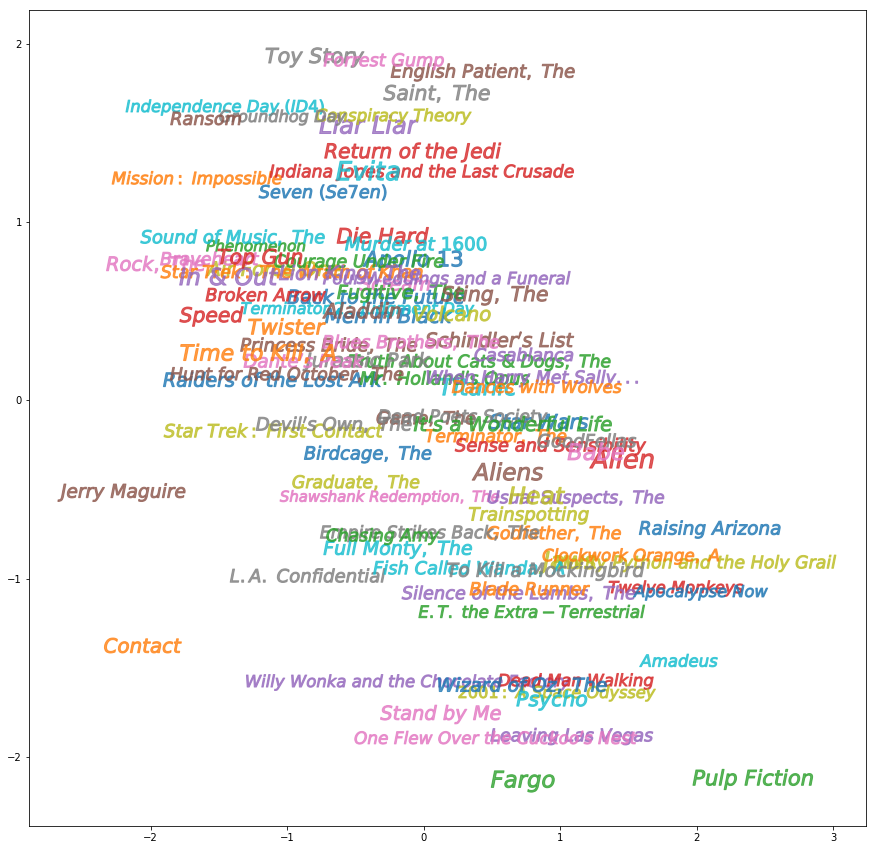

In [44]:
plt.figure(figsize=(15,15))
markers = ["$ {} $".format("\ ".join(m.split(" ")[:-1])) for m in top100["movie_title"]]
for i,item in enumerate(factors):
    l = len(markers[i])
    plt.scatter(item[0], item[1], marker = markers[i], alpha=0.75, s = 50 * (l**2))
plt.show()

# Implementations in `scikit-surprise`

[Surprise](http://surpriselib.com/) contains implementations of many of the same things, so these are tested below. This same dataset is included as a built-in, but for consistency, we may as well load it from our dataframe.

In [28]:
import surprise
from surprise.dataset import Dataset

In [29]:
reader = surprise.Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ml[["user_id", "movie_id", "rating"]], reader)

In [30]:
surprise.model_selection.cross_validate(surprise.NormalPredictor(), data, cv=5)

{'fit_time': (0.10366582870483398,
  0.10604310035705566,
  0.10179662704467773,
  0.1026451587677002,
  0.0964670181274414),
 'test_mae': array([ 1.22489419,  1.22560734,  1.22688242,  1.22222851,  1.20647933]),
 'test_rmse': array([ 1.52458303,  1.52666605,  1.52590029,  1.5226507 ,  1.50655722]),
 'test_time': (0.24164986610412598,
  0.24824905395507812,
  0.24322962760925293,
  0.23812556266784668,
  0.28830456733703613)}

In [31]:
surprise.model_selection.cross_validate(surprise.SlopeOne(), data, cv=5)

{'fit_time': (0.7323219776153564,
  0.7474515438079834,
  0.8048689365386963,
  0.8827495574951172,
  0.6843917369842529),
 'test_mae': array([ 0.74231811,  0.73856994,  0.739769  ,  0.75313973,  0.73952836]),
 'test_rmse': array([ 0.94328575,  0.93975239,  0.94331604,  0.95613001,  0.94051077]),
 'test_time': (2.4415993690490723,
  2.547508478164673,
  2.4010186195373535,
  2.3601694107055664,
  2.3228275775909424)}

In [32]:
surprise.model_selection.cross_validate(surprise.SVD(), data, cv=5)

{'fit_time': (5.507706642150879,
  5.707004547119141,
  5.699196100234985,
  5.936448574066162,
  4.963287591934204),
 'test_mae': array([ 0.73906782,  0.73969865,  0.72716449,  0.7415553 ,  0.73969379]),
 'test_rmse': array([ 0.93793043,  0.94203529,  0.9232864 ,  0.93938017,  0.93863849]),
 'test_time': (0.24920439720153809,
  0.2579805850982666,
  0.24370837211608887,
  0.24422001838684082,
  0.2901029586791992)}